In [22]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

import numpy as np
import cv2
import yaml
import json
from pathlib import Path
import matplotlib as mplt
import matplotlib.pyplot as plt
from dataclasses import dataclass

from calib_utils import *

DATA_ROOT = Path("../../data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Load config and map
config_file = Path(DATA_ROOT / "config.json")
with config_file.open() as f:
    config = json.load(f)

map_file = Path(config["map"]["image"])
im_map = imread_rgb(DATA_ROOT / map_file)

T_map_from_world2 = np.array(config["map"]["T_map_from_world2"])
T_world2_from_map = np.linalg.inv(T_map_from_world2)

zag_elp_cam_016
Number of points in:
  submap corners=2
  floor_polygon=14
  world=6
  image=6
  camera_position_in_world=[-56.97771456  64.52126379   6.        ]


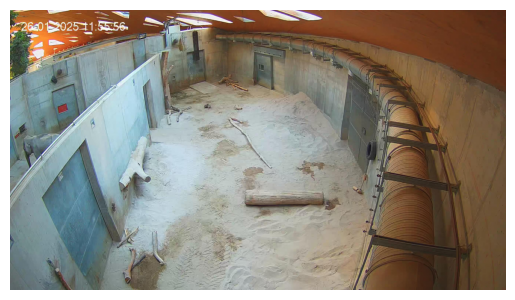

In [24]:
#######################################
# This is the camera we are calibrating
#######################################
# This is the camera we are calibrating
all_camera_names = [
    "elp_kamera_01",
    "zag_elp_cam_016",
    "zag_elp_cam_017",
    "zag_elp_cam_018",
    "zag_elp_cam_019",
]
camera_name = all_camera_names[1] # <------CHANGE HERE
print(camera_name)
########################################

import yaml

with Path("camera_constraints.yaml").open() as f:
    constraints_data = yaml.safe_load(f)

camera_constraints = constraints_data.get(camera_name, None)
if camera_constraints is None:
    raise RuntimeError(
        f"Camera {camera_name} has no constraints, run the selec_camera_constraints script first"
    )
submap_corners_in_map = np.array(camera_constraints["submap_corners_in_map"])
floor_polygon_in_camera = np.array(camera_constraints["floor_polygon"])
constraint_points_in_world = np.array(camera_constraints["floor_matches"]["world"])
constraint_points_in_image = np.array(
    camera_constraints["floor_matches"]["image"] if camera_constraints else None
)
camera_position_in_world = np.array(camera_constraints["camera_position_in_world"])

print(f"Number of points in:")
print(f"  submap corners={submap_corners_in_map.shape[0]}")
print(f"  floor_polygon={floor_polygon_in_camera.shape[0]}")
print(f"  world={constraint_points_in_world.shape[0]}")
print(f"  image={constraint_points_in_image.shape[0]}")
print(f"  camera_position_in_world={camera_position_in_world}")

files = list(DATA_ROOT.glob(f"cameras/{camera_name}/*.jpg"))
assert len(files) > 0, "No image files found in camera dir. Need a sample image."
image_filename = files[0].relative_to(DATA_ROOT)

im_camera = imread_rgb(DATA_ROOT / image_filename)
height, width, _ = im_camera.shape
plt.imshow(im_camera)
plt.gca().set_axis_off()

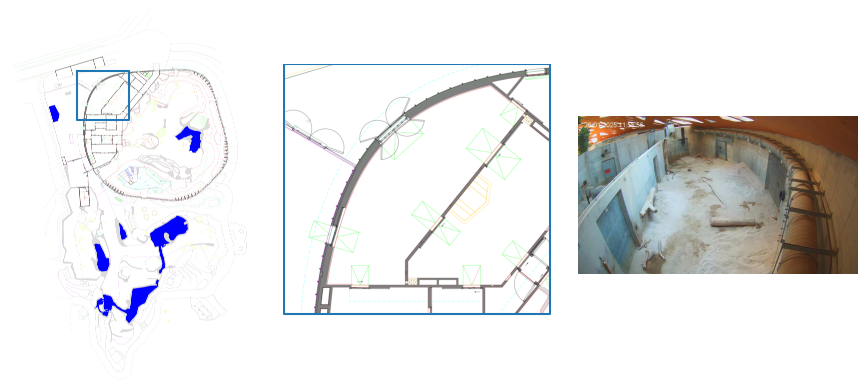

In [25]:
######################################
# Show submap
im_submap = im_map[
    submap_corners_in_map[0, 1] : submap_corners_in_map[1, 1],
    submap_corners_in_map[0, 0] : submap_corners_in_map[1, 0],
    :,
]

T_submap_from_map = np.array(
    [
        [1, 0, -submap_corners_in_map[0, 0]],
        [0, 1, -submap_corners_in_map[0, 1]],
        [0, 0, 1],
    ]
)
T_submap_from_world2 = T_submap_from_map @ T_map_from_world2
T_world2_from_submap = np.linalg.inv(T_submap_from_world2)

submap_corners_in_world2 = hmult(T_world2_from_map, submap_corners_in_map)
submap_corners_in_submap = hmult(T_submap_from_world2, submap_corners_in_world2)


def plot_rectangle_xyxy(ax, points):
    x0, y0 = points[0, 0:2]
    x1, y1 = points[1, 0:2]
    ax.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], "-")


fig, axs = plt.subplots(1, 3, figsize=(9, 4))
axs[0].imshow(im_map)
plot_rectangle_xyxy(axs[0], submap_corners_in_map)
axs[1].imshow(im_submap)
plot_rectangle_xyxy(axs[1], submap_corners_in_submap)
axs[2].imshow(im_camera)
for ax in axs:
    ax.set_axis_off()
fig.tight_layout()

In [26]:
constraint_points_in_world2 = constraint_points_in_world[:, 0:2]
constraint_points_in_submap = hmult(T_submap_from_world2, constraint_points_in_world2)

In [27]:
def plot_projections(H_camera_from_world2: np.ndarray):
    return plot_projections_generic(
        H_camera_from_world2,
        T_submap_from_world2=T_submap_from_world2,
        im_submap=im_submap,
        im_camera=im_camera,
        points_in_image=constraint_points_in_image,
        points_in_world2=constraint_points_in_world2,
        floor_polygon_in_camera=floor_polygon_in_camera,
    )

Inliners 100%
H_world2_from_camera=
[[ 1.30408559e+00  6.44457806e+00  2.11758856e+02]
 [-1.24931960e+00 -8.06637916e+00  2.17285447e+03]
 [-9.19947465e-03 -1.19814043e-01  1.00000000e+00]]
Error (submap units): mean=0.0, max=0.0, sum=0.0
Error (world units): mean=0.18610832367742383, max=0.31712537197108875, sum=1.116649942064543
Error (camera units): mean=0.0, max=0.0, sum=0.0


array([<Axes: >, <Axes: >], dtype=object)

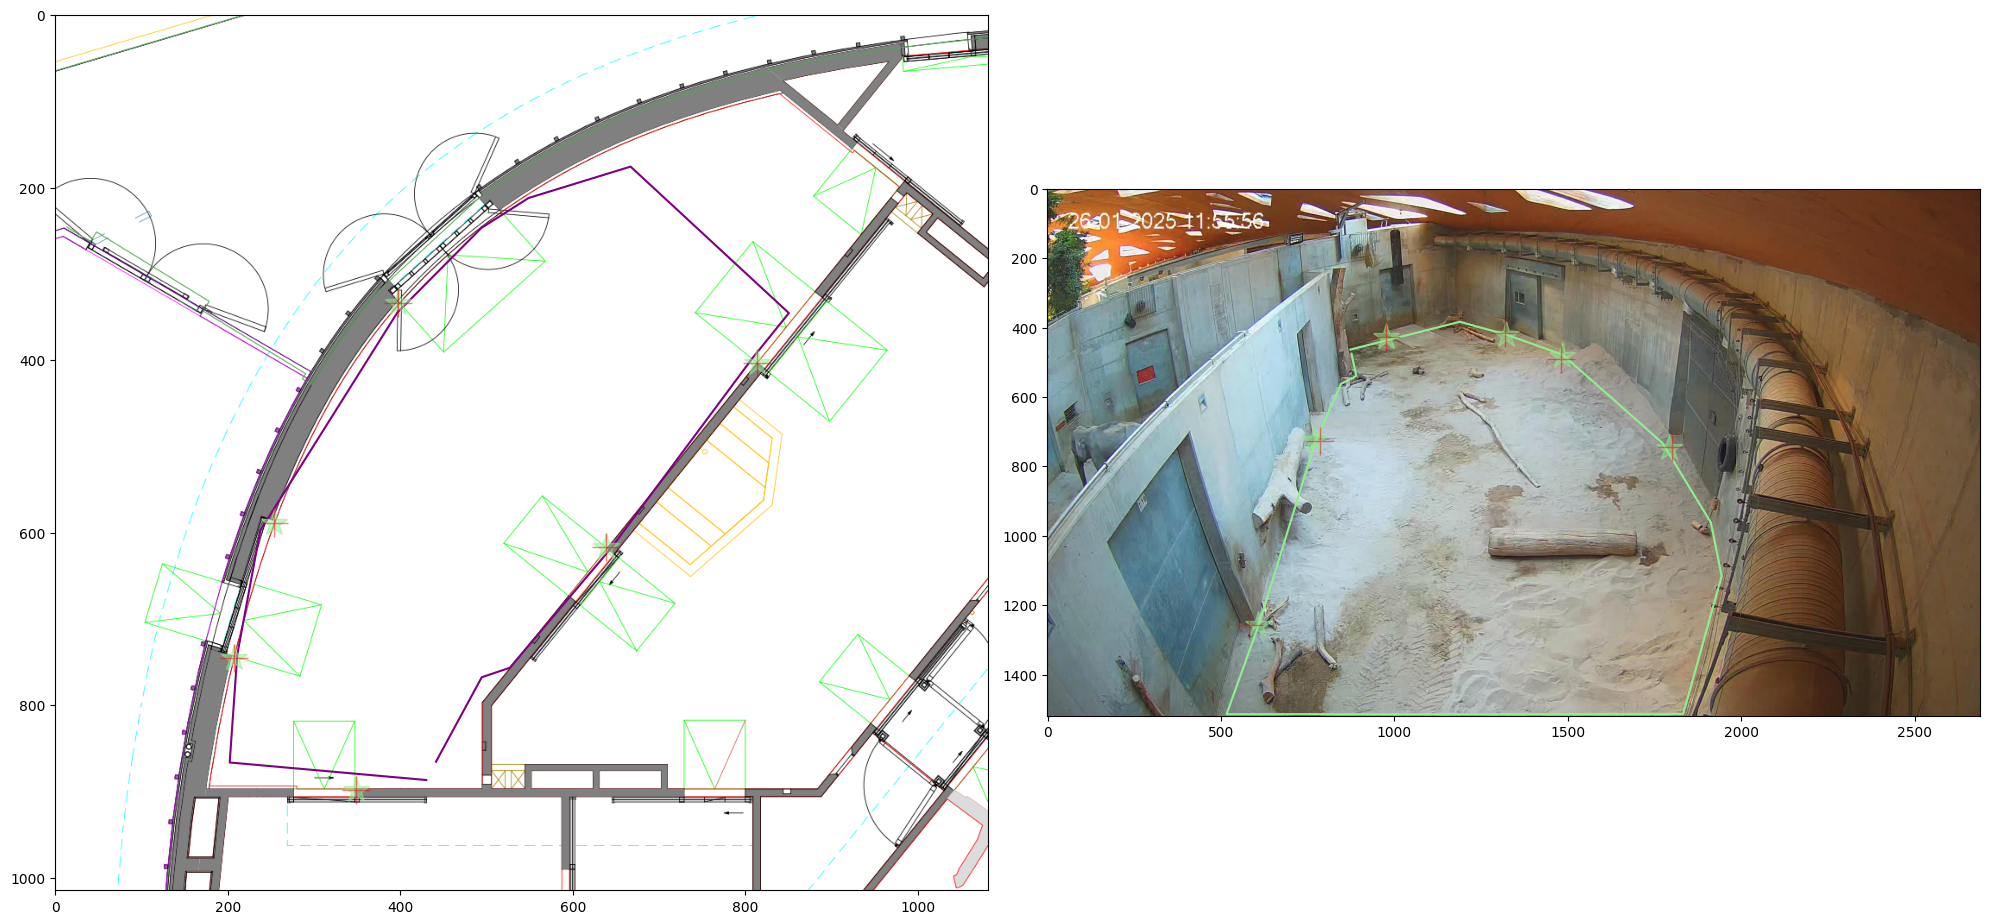

In [28]:
# Find homography through OpenCV
H_world2_from_camera, inliers = cv2.findHomography(
    constraint_points_in_image, constraint_points_in_world2
)
H_camera_from_world2 = np.linalg.inv(H_world2_from_camera)


print(f"Inliners {inliers.sum()/len(inliers):.0%}")
print(f"H_world2_from_camera=\n{H_world2_from_camera}")
plot_projections(H_camera_from_world2)

# H_submap_from_camera = T_submap_from_world2 @ H_world2_from_camera
# H_camera_from_submap = np.linalg.inv(H_submap_from_camera)
# print(f"H_submap_from_camera=\n{H_submap_from_camera}")

# errors = np.mean(np.linalg.norm(constraint_points_in_submap - hmult(H_submap_from_camera, constraint_points_in_image), axis=1))
# print("Mean error (submap units): ", errors)

# errors = np.mean(np.linalg.norm(constraint_points_in_world2  - hmult(H_world2_from_camera, constraint_points_in_image), axis=1))
# print("Mean error (world units): ", errors)

# errors = np.mean(np.linalg.norm(constraint_points_in_image -  hmult(H_camera_from_world2, constraint_points_in_world2), axis=1))
# print("Mean error (camera units): ", errors)

In [29]:
# Dummy 3D calibration using selected position
constraints_center_in_world = np.mean(constraint_points_in_world, axis=0)
constraints_center_in_image = hmult(
    H_camera_from_world2, constraints_center_in_world[0:2]
)
zdir = constraints_center_in_world - camera_position_in_world
zdir = zdir / np.linalg.norm(zdir)

xdir_in_image = constraints_center_in_image + np.array([100, 0])
xdir = to_h(hmult(H_world2_from_camera, xdir_in_image), 0) - camera_position_in_world

ydir = -np.cross(xdir, zdir)
ydir = ydir / np.linalg.norm(ydir)

xdir = np.cross(ydir, zdir)
xdir = xdir / np.linalg.norm(xdir)

R = np.stack([xdir, ydir, zdir], axis=1)
print(R)
# print(camera_position_in_world)

[[-0.74711063  0.23842765 -0.62046592]
 [ 0.66314927  0.20364439 -0.72025135]
 [-0.04537343 -0.94956897 -0.31025801]]


Error (submap units): mean=0.0, max=0.0, sum=0.0
Error (world units): mean=0.18610832367742383, max=0.31712537197108875, sum=1.116649942064543
Error (camera units): mean=0.0, max=0.0, sum=0.0


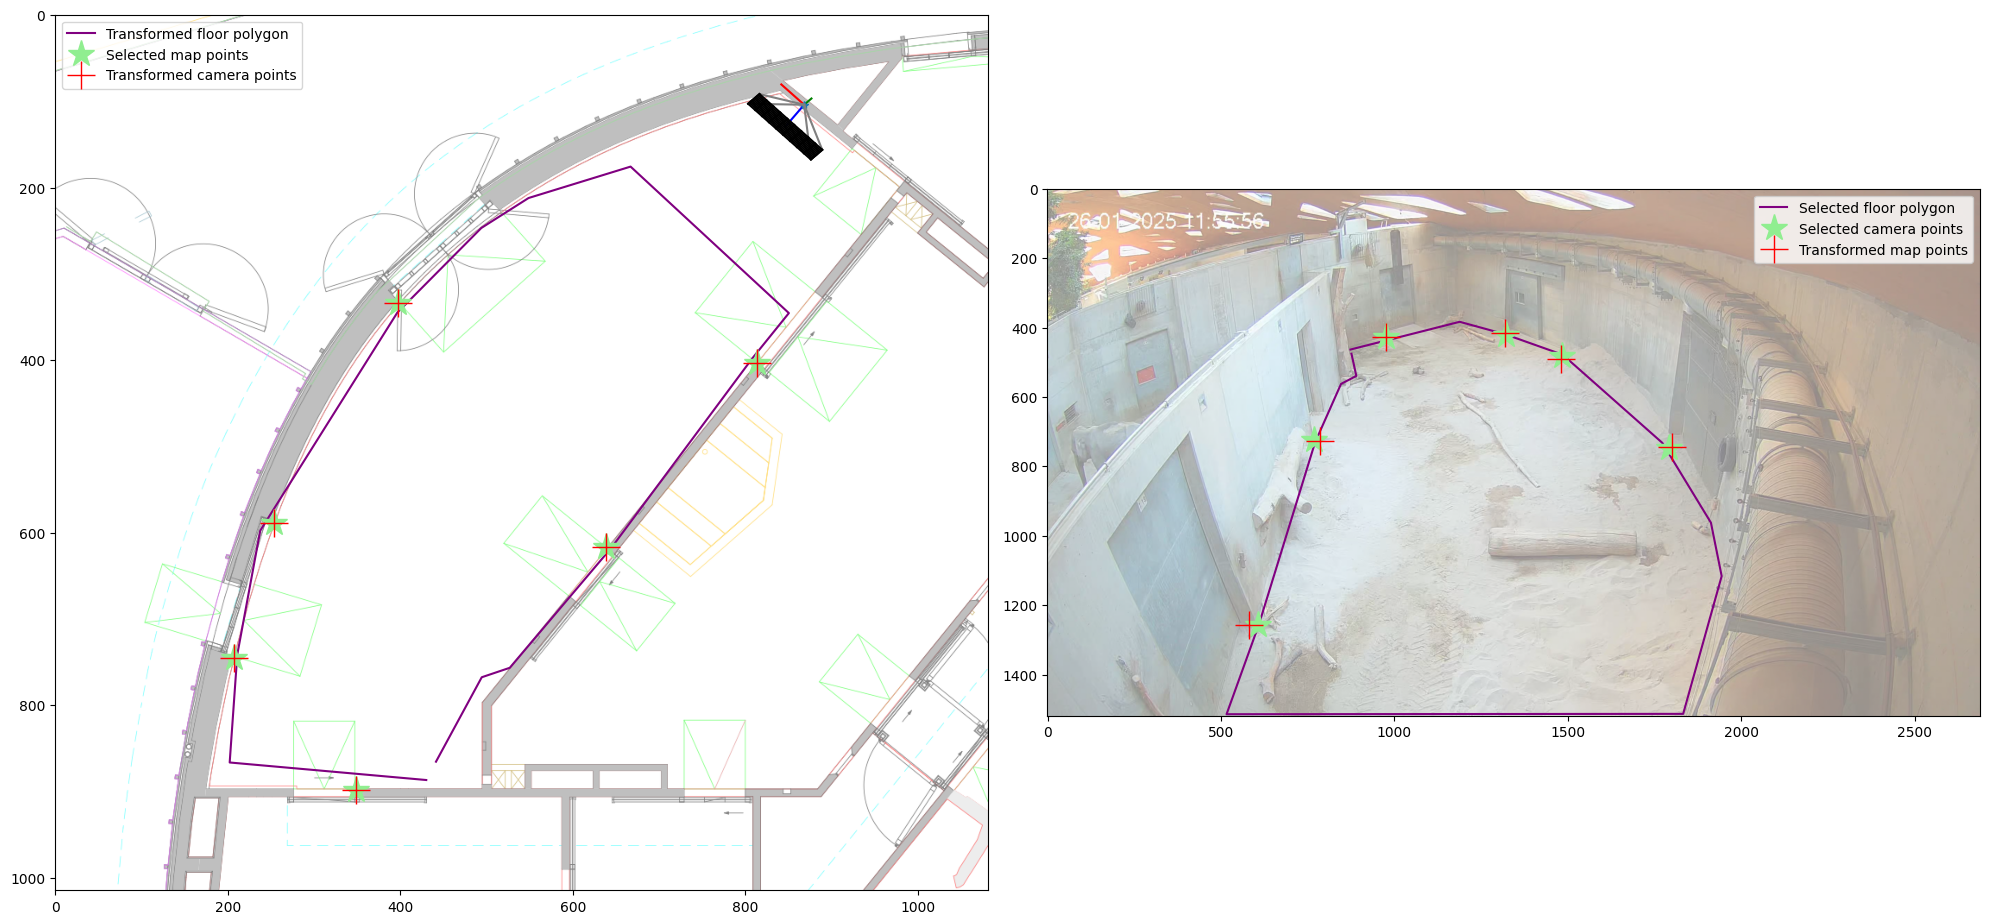

In [ ]:
def plot_Rt_3d(
    ax: mplt.axes.Axes,
    R: np.ndarray,
    t: np.ndarray,
    scale=1,
    T_plot_from_world2=np.eye(3),
):
    x = t + scale * R[:, 0]
    y = t + scale * R[:, 1]
    z = t + scale * R[:, 2]

    tp = hmult(T_plot_from_world2, t[0:2])
    xp = hmult(T_plot_from_world2, x[0:2])
    yp = hmult(T_plot_from_world2, y[0:2])
    zp = hmult(T_plot_from_world2, z[0:2])

    ax.plot([tp[0], xp[0]], [tp[1], xp[1]], "-", color="red")
    ax.plot([tp[0], yp[0]], [tp[1], yp[1]], "-", color="green")
    ax.plot([tp[0], zp[0]], [tp[1], zp[1]], "-", color="blue")


K = K_from_fov(140 * np.pi / 180, np.array([width / 2, height / 2]), width)

axs = plot_projections(H_camera_from_world2)
plot_Rt_3d(
    axs[0],
    R,
    camera_position_in_world,
    scale=1,
    T_plot_from_world2=T_submap_from_world2,
)


def unproject_points(p, depth):
    invK = np.linalg.inv(K)
    xn = hmult(invK, p, keep_h=True)
    x = (R @ xn.T).T * depth + camera_position_in_world
    return x


plot_camera(
    axs[0],
    unproject_points,
    camera_position_in_world,
    width,
    height,
    1,
    T_axes_from_world2=T_submap_from_world2,
)
axs[0].legend()
axs[1].legend()
# plt.gcf().savefig("/home/dherrera/Pictures/interesting/plot.jpg")

In [31]:
# Save config
config["cameras"][camera_name] = {
    "sample_image": str(image_filename),
    "intrinsics": {
        "width": width,
        "height": height,
        "K": K.tolist(),
        "distortion": [0, 0, 0],
        "undistortion": [0, 0, 0],
    },
    "T_world_from_camera": {"R": R.tolist(), "t": camera_position_in_world.tolist()},
    "H_world2_from_camera": H_world2_from_camera.tolist(),
}

with config_file.open("w") as f:
    json.dump(config, f, indent=2)
print(f"Updated camera {camera_name} in config {str(config_file)}")

Updated camera zag_elp_cam_016 in config ../../data/config.json
